# Analysis of NYC Regents Data

The New York State (NYS) Regents exams are assessments that test public school students' understanding of high school learning standards in English, math, science, social studies, and foreign languages. The exams are administered three times ever year: January, June, and August. Students generally must pass a certain number of Regents exams to graduate with a traditional high school diploma. Some middle schools in the state offer accelerated programs that teach the standards and enable students to earn high school credit before matriculation into high school.

In this analysis, I explore the performances of New York City (NYC) public schools on the Regents exams. The analysis starts with an overview of the performance of NYC schools, then it delves more into the differences in performance by English Language Learner (ELL) status and Students with Disability (SWD) status. The time period covered in this analysis is from 2017 to 2023 (excluding 2020 and 2021 due to COVID's impact on the exam administration). The goal is to identify interesting insights into the academic performance of students in the NYC public school system.

Data Source:

2015 to 2023 Regents Exam Results. NYC Public Schools InfoHub. Last accessed in January 2025. https://infohub.nyced.org/reports/academics/test-results

*Disclaimer: Any opinion in this analysis is my own and does not represent the opinion of the NYC education department or my current and previous employers.*

In [1]:
!pip install panel param bokeh jupyter_bokeh -U
!pip install hvplot

import pandas as pd
import numpy as np
import seaborn as sns
import panel as pn
import hvplot.pandas
import hvplot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 64.0 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.9/161.9 kB 4.1 MB/s eta 0:00:00


## Helper Functions

The following functions are used to load, wrangle, and analyze the data from the downloaded Excel file of Regents data.

In [2]:
'''
Filters for rows that have numeric data
'''
def remove_redacted_rows(df):
  return df[df["Mean Score"] != "s"]

'''
Loads in the requested sheet
'''
def load_sheet(filename, sheet):
  return pd.read_excel(filename, sheet_name=sheet)

'''
Corrects the typos in the column names
'''
def correct_col_spelling(df):
  return df.rename(columns={
      "Number meeting CUNY proficiency requirmenets" : "Number meeting CUNY proficiency requirements",
      "Percent meeting CUNY proficiency requirmenets" : "Percent meeting CUNY proficiency requirements"
  })

'''
Changes the data types of specific columns
Total Tested, Number Scoring x, Number meeting: int32
Mean Score, Percent Scoring x, Percent meeting: float32
'''
def change_dtypes(df):

  # turn the na values into numpy nan values
  for col in ["Percent meeting CUNY proficiency requirements", "Number meeting CUNY proficiency requirements"]:
      df.loc[:, col] = df[col].apply(lambda value : np.nan if value == "na" else float(value))

  df = df.astype({
      'Total Tested' : np.int32,
      'Mean Score' : np.float32,
      'Number Scoring Below 65' : np.int32,
      'Percent Scoring Below 65' : np.float32,
      'Number Scoring 65 or Above' : np.int32,
      'Percent Scoring 65 or Above' : np.float32,
      'Number Scoring 80 or Above' : np.int32,
      'Percent Scoring 80 or Above' : np.float32,
      'Number meeting CUNY proficiency requirements' : np.float32,
      'Percent meeting CUNY proficiency requirements' : np.float32,
  })

  return df

'''
Correct the names of the schools due to typos or truncation
New Visions high schools have multiple locations (need to append a number to each one)
New Visions actually changed its name recently but stick to old names for now
Three schools have two DBNs each: Aspirations Diploma Plus High School, Crotona Academy High School, Gotham Professional Arts Academy
These schools probably moved
'''
def correct_names(df):

  ## map a pair of DBN and original name to corrected name
  original_names = []
  with open(r"original_names.txt", "r") as original:
      original_names.extend(original.readlines())

  corrected_names = []
  with open(r"new_names.txt", "r") as new:
      corrected_names.extend(new.readlines())

  corrections_dict = {}

  if len(original_names) != len(corrected_names):
      print("The number of corrections does not match number of incorrect names.")

  else:
      for i in range(len(corrected_names)):
          original_dbn = original_names[i].split("']: ")[0].strip().strip("\n")[2:]
          original_name = original_names[i].split("']: ")[1].strip().strip("\n")

          corrected_name = corrected_names[i].split("']: ")[1].strip().strip("\n")

          corrections_dict[(original_dbn, original_name)] = corrected_name

  # concatenate the DBN and name columns
  placeholder = df["School DBN"] + " +++ " + df["School Name"]
  placeholder = placeholder.apply(lambda value : (value.split(" +++ ")[0], value.split(" +++ ")[1]))

  new_name = placeholder.apply(lambda value : value[1] if corrections_dict.get(value) is None
                               else corrections_dict[value])

  df.loc[:, "School Name"] = new_name

  return df

'''
Rounds the percentages to the ones place
'''
def round_percents(df):

  rounded_percents = []
  for col in ['Percent Scoring Below 65', 'Percent Scoring 65 or Above', 'Percent Scoring 80 or Above',
              'Percent meeting CUNY proficiency requirements', "Mean Score"]:
              df.loc[:, col] = df[col].round(decimals=0)

  return df

'''
Renames the exam names to remove any backslashes
'''
def rename_exams(df):
  reformatted_exam_names = {"Common Core Algebra2" : "Common Core Algebra 2",
                            "Algebra2/Trigonometry" : "Algebra 2 (Trigonometry)",
                            "Physical Settings/Chemistry": "Chemistry",
                            "Physical Settings/Physics" : "Physics",
                            "Physical Settings/Earth Science": "Earth Science"
                            }

  df.loc[:, "Regents Exam"] = df["Regents Exam"].apply(lambda value : value if reformatted_exam_names.get(value) is None
                                                       else reformatted_exam_names[value])

  return df

'''
Remove the old English and math exams before Common Core
'''
def filter_exams(df):
  return df[df["Regents Exam"].isin(['Living Environment', 'Common Core Algebra', 'Common Core English',
                                    'US History and Government', 'Common Core Geometry', 'Global History and Geography',
                                    'Earth Science', 'Spanish', 'Common Core Algebra 2', 'Chemistry', 'Chinese',
                                    'Physics', 'French', 'Italian'])]

'''
Filter for data in the years 2017, 2018, 2019, 2022, 2023
Common Core was still rolling out in 2015 and 2016 for the most part
COVID affected 2020 and 2021 exams
'''
def filter_years(df):
  return df[df["Year"].isin([2017, 2018, 2019, 2022, 2023])]

'''
Adds a column of borough names for the rows
'''
def add_borough_col(df):

  borough_list = []
  for dbn in df["School DBN"]:

      if "X" in dbn:
          borough_list.append("Bronx")

      elif "K" in dbn:
          borough_list.append("Brooklyn")

      elif "R" in dbn:
          borough_list.append("Staten Island")

      elif "Q" in dbn:
          borough_list.append("Queens")

      elif "M" in dbn:
          borough_list.append("Manhattan")

  df["Borough"] = borough_list

  return df

'''
Call on previous helper functions to load, clean, and process a sheet of data
'''
def load_and_process_sheet(filename, sheet):
  df = load_sheet(filename, sheet)
  df = correct_col_spelling(df)
  df = remove_redacted_rows(df)
  df = change_dtypes(df)
  df = rename_exams(df)
  df = add_borough_col(df)
  df = correct_names(df)
  df = filter_years(df)
  df = filter_exams(df)
  return df

'''
Returns the subset with the specified list of exams or the specific exam
'''
def select_exams(df, exams):
  if type(exams) == str:
    return df[df["Regents Exam"].apply(lambda value : True if value == exams else False)]

  return df[df["Regents Exam"].apply(lambda value : True if value in exams else False)]

'''
Returns the subset with the specified years or a specific year
'''
def select_years(df, years):

  # check whether the input is a specific year or an interval
  # and filter accordingly
  if (type(years) == int) or (type(years) == np.int64):
    return df[df["Year"] == years]

  else:
    return df[df["Year"].apply(lambda value : True if value in years else False)]

'''
Returns the subset with the specified list of schools or the specific school
'''
def select_schools(df, schools):
  if type(schools) == str:
    return df[df["School Name"].apply(lambda value : True if value == schools else False)]

  return df[df["School Name"].apply(lambda value : True if value in schools else False)]

## Load in the Data

The data source is an Excel file from the [NYC Public Schools InfoHub](https://infohub.nyced.org/reports/academics/test-results). The file organizes the data into multiple sheets. Each sheet provides useful information about a school's performance on a particular exam in a given year, including, but not limited to, **Mean Score** and **Percent Scoring 65 or Above**. The **Mean Score** is the average of the scores of the students who took the exam in a specific year (i.e. Fort Hamilton High School students received a mean or average score of 72.45 on the US History and Government exams in 2023). Since a grade of 65 is generally the minimum needed to earn high school graduation credit, this analysis will refer to **Percent Scoring 65 or Above** as **Passing Rate**.

For this analysis, I am focusing on only three sheets in the Excel file: **All Students**, **By ELL Status**, and **By SWD Status**.

**All Students**: contains information about every public school's overall performance on the exams every year

**By ELL Status**: provides more fine-grain information by separating the performance data by ELL students, former ELL students, and English Proficient students (English Proficient students are assumed to be students who never had ELL services)*

**By SWD Status**: provides more fine-grain information by separating the performance data by students with disabilities and students without disabilities*

As stated in the **Notes** sheet of the Excel file, the performance of a school on an exam is unavailable if no more than 5 students took the exam in a given year.

The analysis in this entire notebook will focus on the following years: 2017, 2018, 2019, 2022, and 2023. Why?

From 2015 to 2016, NYC was in the process of implementing English and math Regents exams aligned to the Common Core standards. Many students at the time took exams aligned to the pre-Common Core standards, while some students took the newer exams. The data from exams that were aligned to the pre-Common Core standards were removed to focus on more current learning standards. In fact, all exam data before 2017 were removed to make the exam years more consistent.**

Due to COVID, the Regents exams schedule was impacted. The June and August 2020 Regents exams were cancelled, and the 2021 Regents exams were mostly cancelled. The 2020 and 2021 data were removed due to low number of test takers and cancellation of most of the exams.

*For more details about ELL and SWD status, see the Notes sheet in the Excel file.

**Note that a handful of students still took the pre-Common Core exams after 2016, but the vast majority took the Common Core exams.

In [3]:
filename = r"2015_to_2023_regents_data.xlsx"

In [4]:
all_df = load_and_process_sheet(filename, "All Students")
ell_df = load_and_process_sheet(filename, "By ELL Status")
swd_df = load_and_process_sheet(filename, "By SWD Status")

Here is a peek at what the data from **All Students** look like:

In [5]:
# show example information of all_df
all_df.head().hvplot.table(width=2000, height=180)

:Table   [School DBN,School Name,School Type,School Level,Regents Exam,Year,Category,Total Tested,Mean Score,Number Scoring Below 65,Percent Scoring Below 65,Number Scoring 65 or Above,Percent Scoring 65 or Above,Number Scoring 80 or Above,Percent Scoring 80 or Above,Number meeting CUNY proficiency requirements,Percent meeting CUNY proficiency requirements,Borough]

## Citywide Performance by Test


In [6]:
# organize the exams into their respective subjects
ela_exams = ["Common Core English"]
math_exams = ["Common Core Algebra", "Common Core Geometry", "Common Core Algebra 2"]
science_exams = ["Living Environment", "Earth Science", "Chemistry", "Physics"]
social_studies_exams = ["US History and Government", "Global History and Geography"]
foreign_language_exams = ["Chinese", "Spanish", "French", "Italian"]

subjects = ["English", "Math", "Science", "Social Studies", "Foreign Language"]

exams_by_subjects = {
    "English" : ela_exams,
    "Math" : math_exams,
    "Science" : science_exams,
    "Social Studies" : social_studies_exams,
    "Foreign Language" : foreign_language_exams
}

The following code creates three interactive visualizations:

1. The first plot shows the distribution of **Mean Score** and **Passing Rate** of NYC schools on every exam *before* the COVID outbreak from 2017 to 2019.

2. The second plot shows the distribution of **Mean Score** and **Passing Rate** of NYC schools on every exam *after* the COVID outbreak from 2022 to 2023.

3. The third plot shows the median **Mean Score** and **Passing Rate** of NYC schools on every exam from 2017 to 2023 (excluding 2020 and 2021).

In [7]:
'''
Extract a portion of the df with the selected exam from all_df
Focus only on Year, Mean Score, and Passing Rate
'''
def select_exams_years_all(df, exam, year=None):

  subset = select_exams(df, exam)

  if year is not None:
    subset = select_years(subset, year)

  subset = subset.rename(columns={"Percent Scoring 65 or Above" : "Passing Rate"})
  subset = subset[["Year", "Mean Score", "Passing Rate"]]

  # add a row of nan values for 2022 US History and Government (exam was cancelled)
  if exam == 'US History and Government':
    subset = pd.concat([subset, pd.DataFrame({"Year" : [2022], "Mean Score" : [999.0], "Passing Rate" : [999.0]})])
  subset.loc[:, "Mean Score"] = subset["Mean Score"].replace(to_replace = 999.0, value=np.nan)
  subset.loc[:, "Passing Rate"] = subset["Passing Rate"].replace(to_replace = 999.0, value=np.nan)

  subset = subset.sort_values(by="Year")

  return subset

# create a menu to select Mean Score or Passing Rate
avg_or_passing = pn.widgets.Select(name="Mean Score or Passing Rate", value="Mean Score", options=["Mean Score", "Passing Rate"])

# creare a menu to select exam
exam_menu = pn.widgets.Select(name="Exam", groups=exams_by_subjects)

pre_outbreak_years = [2017, 2018, 2019]
post_outbreak_years = [2022, 2023]

# extract the pre-COVID outbreak portion of the df with the selected exam
pre_outbreak = pn.rx(select_exams_years_all)
pre_outbreak = pre_outbreak(all_df, exam_menu, pre_outbreak_years)

# extract the post-COVID outbreak portion of the df with the selected exam
post_outbreak = pn.rx(select_exams_years_all)
post_outbreak = post_outbreak(all_df, exam_menu, post_outbreak_years)

# calculate the yearly medians of the schools' Mean Scores and Passing Rates on the selected exam
yearly_medians = pn.rx(select_exams_years_all)
yearly_medians = yearly_medians(all_df, exam_menu)
yearly_medians = yearly_medians.groupby(by="Year", as_index=False).median()
yearly_medians = yearly_medians.sort_values(by="Year")
yearly_medians = yearly_medians.astype({"Year" : str})

# create the plots
pre_outbreak_distribution = pre_outbreak.hvplot.kde(title="Mean Score or Passing Rate (Pre-COVID Outbreak)", y=avg_or_passing, ylabel="Frequency",
                                                    xlim=(0, 100), line_width=1.5, width=900, hover=False)
post_outbreak_distribution = post_outbreak.hvplot.kde(title="Mean Score or Passing Rate (Post-COVID Outbreak)", y=avg_or_passing, ylabel="Frequency",
                                                      xlim=(0, 100), line_width=1.5, width=900, hover=False)
median_bar = yearly_medians.hvplot.bar(title="Medians of Mean Score or Passing Rate", x="Year", y=avg_or_passing, xlabel="", ylim=(0, 100),
                                       width=900)

pn.Column(
    pre_outbreak_distribution.opts(active_tools=["pan"]),
    post_outbreak_distribution.opts(active_tools=["pan"]),
    median_bar.opts(active_tools=["pan"])
)

Column
    [0] Row
        [0] Row
            [0] WidgetBox
                [0] Select(groups={'English': ['Common Core ...}, name='Exam', value='Common Core English')
                [1] Select(name='Mean Score or P..., options=['Mean Score', ...], value='Mean Score')
            [1] ParamFunction(function, _pane=HoloViews, defer_load=False)
    [1] Row
        [0] Row
            [0] WidgetBox
                [0] Select(groups={'English': ['Common Core ...}, name='Exam', value='Common Core English')
                [1] Select(name='Mean Score or P..., options=['Mean Score', ...], value='Mean Score')
            [1] ParamFunction(function, _pane=HoloViews, defer_load=False)
    [2] Row
        [0] Row
            [0] WidgetBox
                [0] Select(groups={'English': ['Common Core ...}, name='Exam', value='Common Core English')
                [1] Select(name='Mean Score or P..., options=['Mean Score', ...], value='Mean Score')
            [1] ParamFunction(function, _pane=HoloViews, defer_load=False)

For most exams, the distributions of **Mean Score** have one prominent major peak with some outliers at the ends - similar to a bell curve. However, the distributions of the **Passing Rate** tend to not follow a bell-curve. Instead, the distributions tend to be skewed towards either the low or high end. The skewedness indicates that the city consistently had a group of schools that perform either extremely well or extremely poorly. This pattern is especially apparent in the math exam results.

Based on the **Mean Score** medians from 2017 to 2023 (excluding 2020 and 2021), NYC schools demonstrate varying performances on the different exams.

NYC schools had yearly median **Mean Score** values from upper 60% to lower 70% on the Common Core English, indicating overall medicore literacy skills among the test takers. In terms of math, the medians of the Common Core Algebra results were slightly lower. They ranged from middle 60% to upper 60%. Schools generally performed worse on Common Core Algebra 2 and Common Core Geometry, with the latter having the lowest performance among the math exams. In fact, the yearly median **Passing Rates** on the Common Core Geometry and Common Core Algebra 2 were all below 45% and 60%, respectively.

On the science exams, Living Environment had the highest yearly median **Passing Rates** (around 60%). The other exam results were significantly lower. Earth Science had values in the 40s, while Chemistry had values in the 30s. Interestingly, Physics, which is arguably the hardest science exam, had median **Passing Rates** in the 50s before the COVID outbreak.

In terms of social studies, the two exams Global History and Geography and US History and Government showed conflicting trends in the median **Mean Score**. The US History and Government exam decreased from 71% to 67% from 2017 to 2023, but the Global History and Geography increased from 62% to 67%.

Interestingly, the foreign language exams had the highest performances. The **Mean Score** medians were consistently around the 70s and 80s, and the **Passing Rates** were generally at least 80.

As shown by the plots above, the citywide performance on the exams took a dip after the COVID outbreak. Many articles, such as this [Chalkbeat](https://www.chalkbeat.org/newyork/2024/01/08/math-regents-scores-significantly-down-during-pandemic/) article, described the negative effects of the COVID pandemic on student learning. Let's use a heatmap to better visualize the performance drop. The code below calculates the citywide median of the **Mean Score** values for every exam in every year. The higher the median, the darker the color.

*Note that the 2022 US History and Government exam was cancelled.*

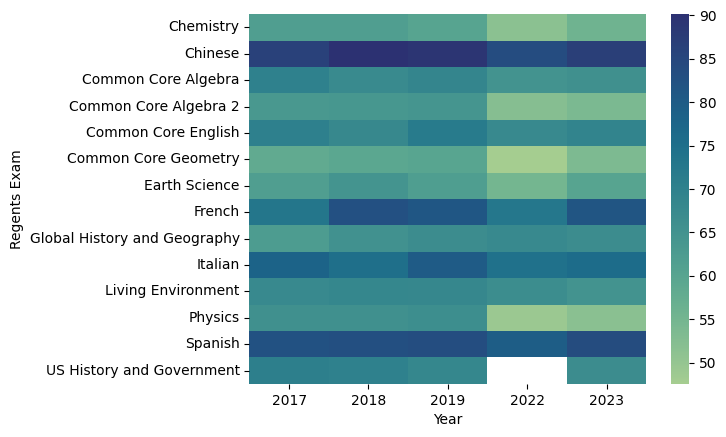

In [8]:
med_mean_scores = all_df[["Year", "Regents Exam", "Mean Score"]].groupby(by=["Year", "Regents Exam"], as_index=False).median()
med_mean_scores = med_mean_scores.pivot(index="Regents Exam", columns="Year", values="Mean Score")
med_mean_scores_hmap = sns.heatmap(med_mean_scores, cmap="crest")

As shown by the heatmap, the color shading for most exams in 2022 and 2023 were lighter than those before 2022. The 2022 drop appears to be most apparent for Common Core Geometry, Common Core Algebra 2, Chemistry, and Physics. Overall, schools showed a decrease in exam performance and, thus, student learning.

The table below shows the differences in the median **Mean Score** and **Passing Rate** before the COVID outbreak (from 2017 to 2019, indicated by "Pre") and after the COVID outbreak (from 2022 to 2023, indicated by "Post"). Every exam, except Global History and Geography, had a lower median in both **Mean Score** and **Passing Rate**.

In [9]:
# iterate through select all exams
# compare the mean scores and passing rates from pre-COVID years (2017-2019) and post-COVID years (2022-2023)
pre_post_COVID_diff = {
    "Exam": [],
    "Pre Median Mean Score" : [],
    "Post Median Mean Score" : [],
    "Diff in Median Mean Score" : [],
    "Pre Median Passing Rate" : [],
    "Post Median Passing Rate" : [],
    "Diff in Median Passing Rate" : []
}

all_df["Pre-COVID"] = all_df["Year"].apply(lambda yr : True if yr < 2020 else False)

for exam in all_df["Regents Exam"].unique():

  pre_COVID_df = all_df[(all_df["Pre-COVID"] == True) & (all_df["Regents Exam"] == exam)]
  post_COVID_df = all_df[(all_df["Pre-COVID"] == False) & (all_df["Regents Exam"] == exam)]

  pre_post_COVID_diff["Exam"].append(exam)

  pre_post_COVID_diff["Pre Median Mean Score"].append(pre_COVID_df["Mean Score"].median())
  pre_post_COVID_diff["Post Median Mean Score"].append(post_COVID_df["Mean Score"].median())
  pre_post_COVID_diff["Diff in Median Mean Score"].append(post_COVID_df["Mean Score"].median() - pre_COVID_df["Mean Score"].median())

  pre_post_COVID_diff["Pre Median Passing Rate"].append(pre_COVID_df["Percent Scoring 65 or Above"].median())
  pre_post_COVID_diff["Post Median Passing Rate"].append(post_COVID_df["Percent Scoring 65 or Above"].median())
  pre_post_COVID_diff["Diff in Median Passing Rate"].append(post_COVID_df["Percent Scoring 65 or Above"].median() - pre_COVID_df["Percent Scoring 65 or Above"].median())

pre_post_COVID_diff_df = pd.DataFrame(pre_post_COVID_diff)
pre_post_COVID_diff_df.hvplot.table(width=1200)

:Table   [Exam,Pre Median Mean Score,Post Median Mean Score,Diff in Median Mean Score,Pre Median Passing Rate,Post Median Passing Rate,Diff in Median Passing Rate]

## Top or Bottom 100 Schools by Exam Mean Score

The code below displays the top or bottom 100 schools based on the schools' median **Mean Score** on a specific exam. Data from from 2017 to 2023 (excluding 2020 and 2021) are included. The median number of test takers is also included to give more context.

Interestingly, a noticeable number of schools in the top 100 for Common Core Algebra, Living Environment, and Earth Science were middle schools (indicated by "M.S.", "I.S.", or "J.H.S." in their names). These results came from middle school students taking accelerated high school coursework.

In [10]:
def find_top_or_bottom_schools_rx(df, exam, kind):

  subset = select_exams(df, exam)
  subset = subset[["School Name", "Mean Score", "Total Tested"]]

  medians = subset.groupby(by="School Name", as_index=False).median()

  if kind == "Top 100":
    medians = medians.sort_values(by=["Mean Score", "Total Tested"], ascending=False)
  else:
    medians = medians.sort_values(by=["Mean Score", "Total Tested"])

  medians.loc[:, "Mean Score"] = medians["Mean Score"]
  medians.loc[:, "Total Tested"] = medians["Total Tested"]
  medians = medians.rename(columns={"Mean Score" : "Median Mean Score", "Total Tested" : "Median Number of Test Takers"})

  return medians.head(100)

exam_menu = pn.widgets.Select(name="Exam", groups=exams_by_subjects)
top_or_bottom_menu = pn.widgets.Select(name="Top or Bottom 100", options=["Top 100", "Bottom 100"])

top_or_bottom_100_schools = pn.rx(find_top_or_bottom_schools_rx)
top_or_bottom_100_schools = top_or_bottom_100_schools(all_df, exam_menu, top_or_bottom_menu)

pn.Row(
    top_or_bottom_100_schools.hvplot.table(title="Top 100 or Bottom 100 Schools by Median Mean Score", width=1000)
)

Row
    [0] Row
        [0] Row
            [0] WidgetBox
                [0] Select(groups={'English': ['Common Core ...}, name='Exam', value='Common Core English')
                [1] Select(name='Top or Bottom 100', options=['Top 100', 'Bottom 100'], value='Top 100')
            [1] ParamFunction(function, _pane=HoloViews, defer_load=False)

## Performance of SWD vs Non-SWD

In this section, I compare the performance of students with disabilities and students without disabilities. I first compare the medians in **Mean Scores** and **Passing Rates** from 2017 to 2023 (excluding 2020 and 2021) for every exam. You can use the dropdown menu in the interactive visualization to select the exam.

It is important to explain how the median **Mean Score** and **Passing Rate** are calculated. The data source provides the mean score and passing rate of SWD and non-SWD students in every NYC school. The median **Mean Score** and **Passing Rate** are calculated by finding the medians of those values from the data source.

In [11]:
'''
Extract a portion of the df with the selected exam
'''
def select_exams_swd(df, exam):

  subset = select_exams(df, exam)
  subset = subset.rename(columns={"Percent Scoring 65 or Above" : "Passing Rate"})
  subset = subset[["Category", "Mean Score", "Passing Rate"]]
  subset = subset.sort_values(by="Category")

  return subset

avg_or_passing = pn.widgets.Select(name="Mean Score or Passing Rate", value="Mean Score", options=["Mean Score", "Passing Rate"])
exam_menu = pn.widgets.Select(name="Exam", groups=exams_by_subjects)

exam_subset = pn.rx(select_exams_swd)
exam_subset = exam_subset(swd_df, exam_menu)

# calculate median of SWD vs non-SWD from all the available years
avgs_by_swd_status = exam_subset.groupby(by="Category", as_index=False).median()

# set up the number box css styles
number_styles={"box-shadow" : "0px 1px 3px 1px gray"}

# create number boxes to display medians for SWD and non-SWD students
swd_med_num = pn.indicators.Number(name="SWD Median",
                                   value=avgs_by_swd_status[avgs_by_swd_status["Category"] == "SWD"][avg_or_passing].sum(),
                                   format="{value:,.1f}",
                                   title_size="1.5rem",
                                   font_size="1.3rem",
                                   margin=20,
                                   styles=number_styles
                                   )
non_swd_med_num = pn.indicators.Number(name="Non-SWD Median",
                                       value=avgs_by_swd_status[avgs_by_swd_status["Category"] == "Non-SWD"][avg_or_passing].sum(),
                                       format="{value:,.1f}",
                                       title_size="1.5rem",
                                       font_size="1.3rem",
                                       margin=20,
                                       styles=number_styles
                                       )

density_plot = exam_subset.hvplot.kde(y=avg_or_passing, by="Category", xlim=(0, 100), alpha=0.5, hover=False)

pn.Column(
    pn.Row(
        swd_med_num,
        non_swd_med_num,
        styles={"margin" : "auto"}
    ),
    density_plot.opts(active_tools=["pan"]),

)

Column
    [0] Row(styles={'margin': 'auto'})
        [0] Number(font_size='1.3rem', format='{value:,.1f}', margin=20, name='SWD Median', styles={'box-shadow': '...}, title_size='1.5rem', value=60.136246)
        [1] Number(font_size='1.3rem', format='{value:,.1f}', margin=20, name='Non-SWD Median', styles={'box-shadow': '...}, title_size='1.5rem', value=72.537025)
    [1] Row
        [0] Row
            [0] WidgetBox
                [0] Select(groups={'English': ['Common Core ...}, name='Exam', value='Common Core English')
                [1] Select(name='Mean Score or P..., options=['Mean Score', ...], value='Mean Score')
            [1] ParamFunction(function, _pane=HoloViews, defer_load=False)

If you explore the visualization, you will notice that SWD consistently performed lower than non-SWD. For more detailed differences in the performances, the code below presents them in a table.

In [12]:
# iterate through each exam
# calculate the diff in performances of SWD and non-SWD students
# takes into account of data from all years
test_results_swd = {"Exam": [],
                    "SWD Median Mean Score" : [],
                    "Non-SWD Median Mean Score" : [],
                    "Diff in Median Mean Score" : [],
                    "SWD Median Passing Rate" : [],
                    "Non-SWD Median Passing Rate" : [],
                    "Diff in Median Passing Rate" : []
                    }

exams = list(swd_df["Regents Exam"].unique())

for exam in exams:

  subset = select_exams(swd_df, exam)

  swd_med_mean_score = subset[subset["Category"] == "SWD"]["Mean Score"].median()
  non_swd_med_mean_score = subset[subset["Category"] == "Non-SWD"]["Mean Score"].median()

  swd_med_passing_rate = subset[subset["Category"] == "SWD"]["Percent Scoring 65 or Above"].median()
  non_swd_med_passing_rate = subset[subset["Category"] == "Non-SWD"]["Percent Scoring 65 or Above"].median()

  test_results_swd["Exam"].append(exam)

  test_results_swd["SWD Median Mean Score"].append(swd_med_mean_score)
  test_results_swd["Non-SWD Median Mean Score"].append(non_swd_med_mean_score)
  test_results_swd["Diff in Median Mean Score"].append(swd_med_mean_score - non_swd_med_mean_score)

  test_results_swd["SWD Median Passing Rate"].append(swd_med_passing_rate)
  test_results_swd["Non-SWD Median Passing Rate"].append(non_swd_med_passing_rate)
  test_results_swd["Diff in Median Passing Rate"].append(swd_med_passing_rate - non_swd_med_passing_rate)

test_results_df = pd.DataFrame(test_results_swd).sort_values(by=["Diff in Median Mean Score", "Diff in Median Passing Rate"])
test_results_df.hvplot.table(width=1300, height=180)

:Table   [Exam,SWD Median Mean Score,Non-SWD Median Mean Score,Diff in Median Mean Score,SWD Median Passing Rate,Non-SWD Median Passing Rate,Diff in Median Passing Rate]

If we take a look at the Common Core English exam, the difference in median **Passing Rate** is 30%. The math exams also show a big gap, with the largest gap being 40% for Common Core Algebra. Interestingly, Physics has the lowest difference in performance: 15% for median **Passing Rate** and 7% for median **Mean Score**. Physics is a relatively difficult course that requires strong algebra skills. Many schools probably only allow high-performing students to take the Physics course, so SWD students who took Physics likely had strong academic skills. Meanwhile, the other science courses had SWD students of varying performance levels, resulting in drastically larger differences in median **Mean Scores** and **Passing Rates**.

## Performance of ELL vs Non-ELL

In this section, I will repeat the same analysis as above for ELL groups: ELL students, former ELL students, and English Proficient students (English Proficient students are assumed to never had been ELL students).

It is important to explain how the median **Mean Score** and **Passing Rate** are calculated. The data source provides the mean score and passing rate of ELL, English Proficient, and Former ELL students in every NYC school. The median **Mean Score** and **Passing Rate** are calculated by finding the medians of those values from the data source.

In [13]:
'''
Extract a portion of the df with the selected exam
'''
def select_exams_ell(df, exam):

  subset = select_exams(df, exam)
  subset = subset.rename(columns={"Percent Scoring 65 or Above" : "Passing Rate"})
  subset = subset[["Category", "Mean Score", "Passing Rate"]]
  subset = subset.sort_values(by="Category")

  # there is no record of ELL students taking Italian in the available years
  # add a nan row for ELL students
  if exam == "Italian":
    subset = pd.concat([subset, pd.DataFrame({"Category" : ["ELL"], "Mean Score" : [999.9], "Passing Rate" : [999.9]})])
    subset.loc[:, "Mean Score"] = subset["Mean Score"].replace(to_replace=999.9, value=np.nan)
    subset.loc[:, "Passing Rate"] = subset["Passing Rate"].replace(to_replace=999.9, value=np.nan)

  return subset

avg_or_passing = pn.widgets.Select(name="Mean Score or Passing Rate", value="Mean Score", options=["Mean Score", "Passing Rate"])
exam_menu = pn.widgets.Select(name="Exam", groups=exams_by_subjects)

exam_subset = pn.rx(select_exams_ell)
exam_subset = exam_subset(ell_df, exam_menu)

# calculate medians of English proficient, former ELL, and current ELL students from all the available years
med_by_ell_status = exam_subset.groupby(by="Category", as_index=False).median()

# set up the number box css styles
number_styles={"box-shadow" : "0px 1px 3px 1px gray"}

# create number boxes to display medians for English proficient, former ELL, and current ELL students
proficient_med_num = pn.indicators.Number(name="English Proficient Median",
                                          value=med_by_ell_status[med_by_ell_status["Category"] == "English Proficient"][avg_or_passing].median(),
                                          format="{value:,.1f}",
                                          title_size="1.5rem",
                                          font_size="1.3rem",
                                          margin=20,
                                          styles=number_styles,
                                          nan_format="NA"
                                          )

former_ell_med_num = pn.indicators.Number(name="Former ELL Median",
                                          value=med_by_ell_status[med_by_ell_status["Category"] == "Former ELL"][avg_or_passing].median(),
                                          format="{value:,.1f}",
                                          title_size="1.5rem",
                                          font_size="1.3rem",
                                          margin=20,
                                          styles=number_styles,
                                          nan_format="NA"
                                          )

ell_med_num = pn.indicators.Number(name="ELL Median",
                                   value=med_by_ell_status[med_by_ell_status["Category"] == "ELL"][avg_or_passing].median(),
                                   format="{value:,.1f}",
                                   title_size="1.5rem",
                                   font_size="1.3rem",
                                   margin=20,
                                   styles=number_styles,
                                   nan_format="NA"
                                   )

ell_density_plot = exam_subset.hvplot.kde(y=avg_or_passing, by="Category", xlim=(0, 100), alpha=0.5, hover=False)

pn.Column(
    pn.Row(
        ell_med_num,
        proficient_med_num,
        former_ell_med_num,
        styles={"margin" : "auto"}
    ),

    ell_density_plot.opts(active_tools=["pan"])
)

Column
    [0] Row(styles={'margin': 'auto'})
        [0] Number(font_size='1.3rem', format='{value:,.1f}', margin=20, name='ELL Median', nan_format='NA', styles={'box-shadow': '...}, title_size='1.5rem', value=52.414215087890625)
        [1] Number(font_size='1.3rem', format='{value:,.1f}', margin=20, name='English Proficient M..., nan_format='NA', styles={'box-shadow': '...}, title_size='1.5rem', value=71.95384979248047)
        [2] Number(font_size='1.3rem', format='{value:,.1f}', margin=20, name='Former ELL Median', nan_format='NA', styles={'box-shadow': '...}, title_size='1.5rem', value=74.89051818847656)
    [1] Row
        [0] Row
            [0] WidgetBox
                [0] Select(groups={'English': ['Common Core ...}, name='Exam', value='Common Core English')
                [1] Select(name='Mean Score or P..., options=['Mean Score', ...], value='Mean Score')
            [1] ParamFunction(function, _pane=HoloViews, defer_load=False)

As illustrated by the distributions, ELL students tended to have the lowest performance and former ELL students tended to have the highest performance.

In [14]:
# iterate through each available exam
# calculate the diff in performances of ELL, former ELL, and English proficient students
# takes into account of data from all years
test_results_ell = {"Exam": [],
                    "ELL Median Mean Score" : [],
                    "English Proficient Median Mean Score" : [],
                    "Former ELL Median Mean Score" : [],
                    "ELL Median Passing Rate" : [],
                    "English Proficient Median Passing Rate" : [],
                    "Former ELL Median Passing Rate" : []
                    }

for exam in exams:

  subset = select_exams(ell_df, exam)

  # calculate median mean score by ELL status
  ell_med_mean_score = subset[subset["Category"] == "ELL"]["Mean Score"].median()
  proficient_med_mean_score = subset[subset["Category"] == "English Proficient"]["Mean Score"].median()
  former_ell_med_mean_score = subset[subset["Category"] == "Former ELL"]["Mean Score"].median()

  # calculate median passing rate by ELL status
  ell_med_passing_rate = subset[subset["Category"] == "ELL"]["Percent Scoring 65 or Above"].median()
  proficient_med_passing_rate = subset[subset["Category"] == "English Proficient"]["Percent Scoring 65 or Above"].median()
  former_ell_med_passing_rate = subset[subset["Category"] == "Former ELL"]["Percent Scoring 65 or Above"].median()

  test_results_ell["Exam"].append(exam)

  test_results_ell["ELL Median Mean Score"].append(ell_med_mean_score)
  test_results_ell["English Proficient Median Mean Score"].append(proficient_med_mean_score)
  test_results_ell["Former ELL Median Mean Score"].append(former_ell_med_mean_score)

  test_results_ell["ELL Median Passing Rate"].append(ell_med_passing_rate)
  test_results_ell["English Proficient Median Passing Rate"].append(proficient_med_passing_rate)
  test_results_ell["Former ELL Median Passing Rate"].append(former_ell_med_passing_rate)


test_results_df = pd.DataFrame(test_results_ell)
test_results_df.hvplot.table(width=1500, height=180)

:Table   [Exam,ELL Median Mean Score,English Proficient Median Mean Score,Former ELL Median Mean Score,ELL Median Passing Rate,English Proficient Median Passing Rate,Former ELL Median Passing Rate]

It is unsurprising that ELL students performed worse than students who are English proficient. Without sufficient English proficiency, learning is a struggle in all subjects. Interestingly, former ELL students outperformed English proficient students on every Regents exam. The exams that are heavy on English reading and writing are Common Core English, Global History and Geography, and US History and Government. Former ELL students surpassed English proficient students by about 3% and surpassed ELL students by over 10% on those exams in terms of median **Mean Score**. Former ELL students have already overcome the language barrier and become proficient in English. Overcoming the language barrier requires effort, self-reflection, and metacognitive abilities. In other words, former ELL students gained experience and abilities that can be transferred to areas outside of English. This is probably why they performed better than their peers. Studies have shown that bilingualism and academic performance are positively correlated (see this [Edutopia](https://www.edutopia.org/article/benefits-being-bilingual/) article for more information).

## Summary

This analysis of Regents exams results reveal insights into the academic performance of NYC schools on high school-level content.

*   The city's performance on the exams in English, math, science, and social studies are medicore. The annual median **Mean Score** on the exams is generally in the 60s. The performance on the foreign language exams tend to be higher. The annual median **Mean Score** is in the 70s to 80s range.
*   The performance on the Regents exams dropped after the COVID outbreak. The impact is largest on the Common Core Geometry, Common Core Algebra 2, Chemistry, and Physics exams.
*  SWD students tend to perform lower than non-SWD students on the Regents exams. The usual difference in median **Passing Rate** is around 20% or 30%, depending on the exam.
*  ELL students tend to perform worse than their peers, while former ELL students tend to outperform everyone else. This pattern suggests a correlation between overcoming the language barrier and high academic achievement.

Based on the trends, the city schools will need some time to regain to their former performance levels before the COVID outbreak. The 2024 data was not available at the time of this analysis. It would be interesting to have that data to check the progress in restoring back to pre-COVID levels. On another note, the data illustrate a need for more SWD and ELL support. The gaps in performance among SWD groups and ELL groups are noticeably large. Future citywide school planning should involve more investment in programs and services for ELL and SWD students.